In [2]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [3]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [4]:
import numpy as np
import torch

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [5]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [35]:
import torch.nn as nn
import torch.nn.functional as F

class TVEC(nn.Module):
    def __init__(self, inp, lambd=0, beta=1e2, dim=10, lag=1):
        super(TVEC, self).__init__()
        self.lag = lag
        self.N = inp.shape[0]
        self.R = inp.shape[1]
        self.T = inp.shape[2]-self.lag
#         self.base = torch.eye(n).float().cuda()
#         self.base = nn.Parameter(self.base)
        self.A = torch.randn(self.N,self.T,self.R,dim).float().cuda()/self.R
        self.A = nn.Parameter(self.A)
        self.lambd = lambd
        self.beta = beta
        self.dp = nn.Dropout(p=0.1)
#         self.eye = torch.eye(n).float().cuda()

    def predict(self, x, A):
        w = torch.einsum('abc,adc->abd',A,A)
        xhat = torch.einsum('abd,ba->da',w,x[:,:-self.lag])
        return xhat,w
        
    def forward(self, x):
        x = self.dp(x)
        xhat = torch.zeros(self.N,self.R,self.T).float().cuda()
        for sub in range(self.N):
            xhat[sub],_ = self.predict(x[sub], self.A[sub])
        sim = torch.sum((xhat-x[:,:,self.lag:])**2)
        diff = self.beta*torch.sum((self.A-torch.mean(self.A, dim=(0,1)))**2)
#         diff = self.beta*torch.sum((w[1:]-w[:-1])**2)
        return [sim,diff]
    
nEpochs = 4000
pPeriod = 100

X = nback_t[0:20]

tvec = TVEC(X,lambd=0,beta=1e0,dim=10,lag=1)
optim = torch.optim.Adam(tvec.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-6)

for epoch in range(nEpochs):
    loss = tvec(X)
    sum(loss).backward()
    optim.step()
    sched.step(loss[1])
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {[float(part) for part in loss]}')
        
print('Complete')

0 [9157.361328125, 174.2467041015625]
100 [7031.4970703125, 5490.33349609375]
200 [6340.19970703125, 8330.8515625]
300 [4997.10791015625, 8213.244140625]
400 [4399.7744140625, 7055.40185546875]
500 [3917.725341796875, 5868.6455078125]
600 [3666.595703125, 4918.56298828125]
700 [3449.50830078125, 4249.80517578125]
800 [3264.6552734375, 3804.38427734375]
900 [3126.30615234375, 3494.21875]
1000 [3027.69189453125, 3218.65185546875]
1100 [2937.08740234375, 3002.15625]
1200 [2893.7890625, 2861.8447265625]
1300 [2876.095947265625, 2792.91015625]
1400 [2869.62109375, 2780.1474609375]
1500 [2867.04736328125, 2804.692626953125]
1600 [2862.30712890625, 2847.7158203125]
1700 [2853.552734375, 2892.56982421875]
1800 [2842.47216796875, 2925.9453125]
1900 [2825.22509765625, 2939.023193359375]
2000 [2808.12548828125, 2928.216796875]
2100 [2784.754638671875, 2895.35595703125]
2200 [2772.4482421875, 2847.13720703125]
2300 [2748.7314453125, 2793.2275390625]
2400 [2733.26318359375, 2743.19921875]
2500 [271

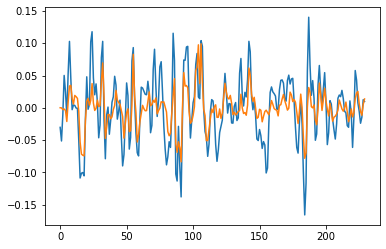

In [45]:
import matplotlib.pyplot as plt

sub = 0
roi = 4

with torch.no_grad():
    xhat,w = tvec.predict(X[sub], tvec.A[sub])
    xhat = xhat.detach().cpu().numpy()

plt.plot(X[sub,roi,1:].detach().cpu().numpy())
plt.plot(xhat[roi])
plt.show()

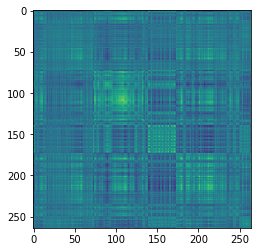

In [52]:
plt.imshow(w[18].detach().cpu().numpy())
plt.show()